# How to set the Operating Point
This tutorial explains how to use the object InputCurrent and VarLoadCurrent to run a magnetic simulation on several operating points by setting Id/Iq or I0/Phi0.

The reference used to validate this tutorial is: Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range," 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

## Machine and Simulation definition
This tutorial use the machine IPMSM_A (Prius 2004) defined in the "[How to define a machine](https://pyleecan.org/tuto_Machine.html)" tutorial. The magnetic module is the same as the symmetrical one from the tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)".

<IPython.core.display.Javascript object>


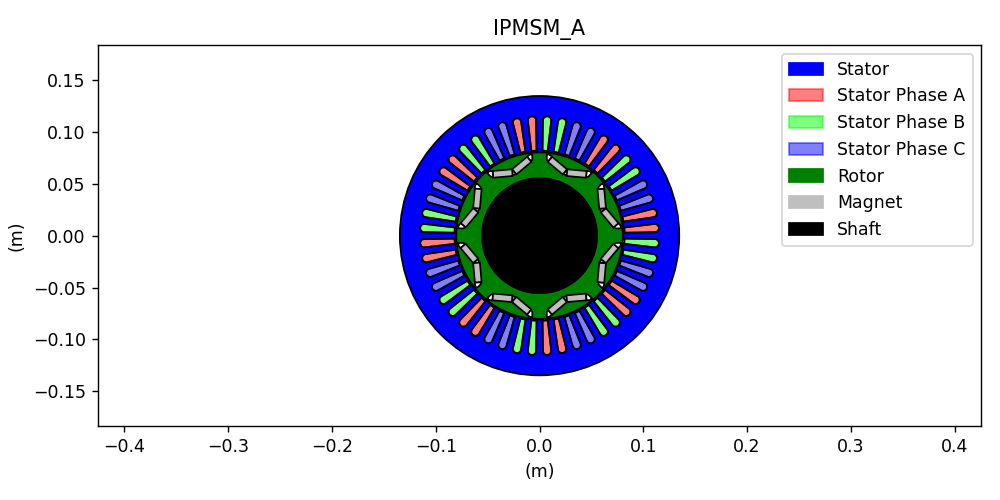

In [1]:
%matplotlib notebook

# Load the machine
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

IPMSM_A = load(join(DATA_DIR, "Machine", "IPMSM_A.json"))
IPMSM_A.plot()

In [2]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
# Initialization of the Simulation
simu_op = Simu1(name="tuto_Id_Iq", machine=IPMSM_A)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu_op.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    Kgeo_fineness=1,
)
# Run only Magnetic module
simu_op.elec = None
simu_op.force = None
simu_op.struct = None

## Defining an Operating point with Id/Iq

The InputCurrent object enable to create an "OutElec" object that corresponds to the output of the Electrical module and the input of the Magnetic module. In this example, InputCurrent is used to define the starting point with a sinusoidal current defined with Id_ref and Iq_ref:

The tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)" uses the same InputCurrent object to enforce any current by directly setting Is

In [3]:
from pyleecan.Classes.InputCurrent import InputCurrent
from numpy import sqrt, exp,pi

# Definition of a sinusoidal current
simu_op.input = InputCurrent()
# I0, Phi0 to set
I0_rms = 250/sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp
# Compute corresponding Id/Iq
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag
# Setting the values
simu_op.input.Id_ref = Id_ref # [Arms] 
simu_op.input.Iq_ref = Iq_ref # [Arms] 

(Id_ref,Iq_ref)

(-135.4188051049254, 113.62986941801093)

The discretization of the current and for the magnetic computation can be set with time and angle (as in "[How to define a simulation to call FEMM](https://pyleecan.org/tuto_Simulation_FEMM.html)" tutorial) or by setting the following parameters:

In [4]:
simu_op.input.Nt_tot = 128 # Number of time step
simu_op.input.Na_tot = 2048 # Spatial discretization
simu_op.input.N0 = 2000 # Rotor speed [rpm]

When Nt_tot is defined, the time vector is automatically set to:

    linspace(0, 60 / N0 * Nrev, Nt_tot)

With Nrev the number of revolution of the rotor (1 by default)

When Na_tot is defined, the angle vector is automatically set to:

    linspace(0, 2*pi, Na_tot)

The input is now fully defined, the simulation can now be run:

[14:37:28] Starting running simulation tuto_Id_Iq (machine=IPMSM_A)
[14:37:28] Starting Magnetic module
[14:37:29] Solving time step 9 / 16 in FEMM
[14:37:29] Solving time step 5 / 16 in FEMM
[14:37:29] Solving time step 1 / 16 in FEMM
[14:37:29] Solving time step 13 / 16 in FEMM
[14:37:31] Solving time step 10 / 16 in FEMM
[14:37:31] Solving time step 6 / 16 in FEMM
[14:37:31] Solving time step 2 / 16 in FEMM
[14:37:31] Solving time step 14 / 16 in FEMM
[14:37:33] Solving time step 11 / 16 in FEMM
[14:37:33] Solving time step 7 / 16 in FEMM
[14:37:33] Solving time step 3 / 16 in FEMM
[14:37:34] Solving time step 15 / 16 in FEMM
[14:37:35] Solving time step 12 / 16 in FEMM
[14:37:35] Solving time step 8 / 16 in FEMM
[14:37:35] Solving time step 4 / 16 in FEMM
[14:37:36] Solving time step 16 / 16 in FEMM
[14:37:38] End of simulation tuto_Id_Iq


<IPython.core.display.Javascript object>


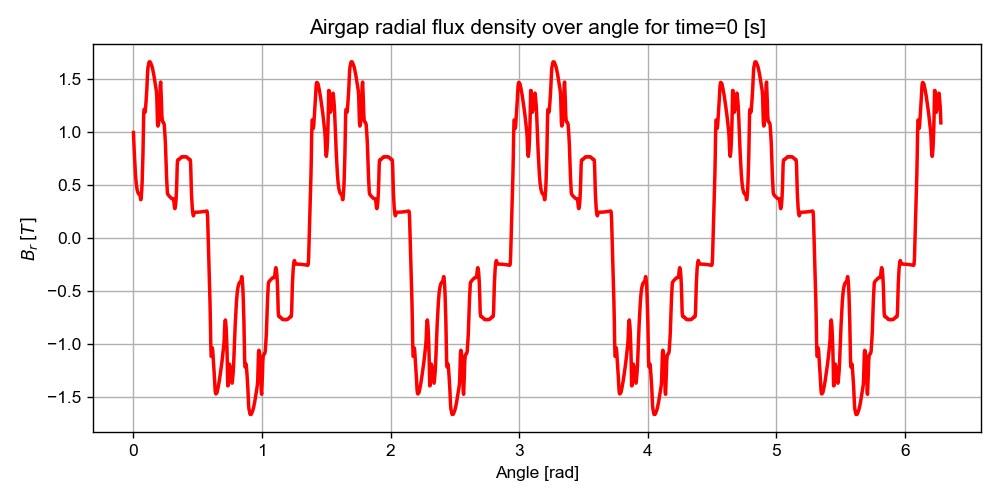

<IPython.core.display.Javascript object>


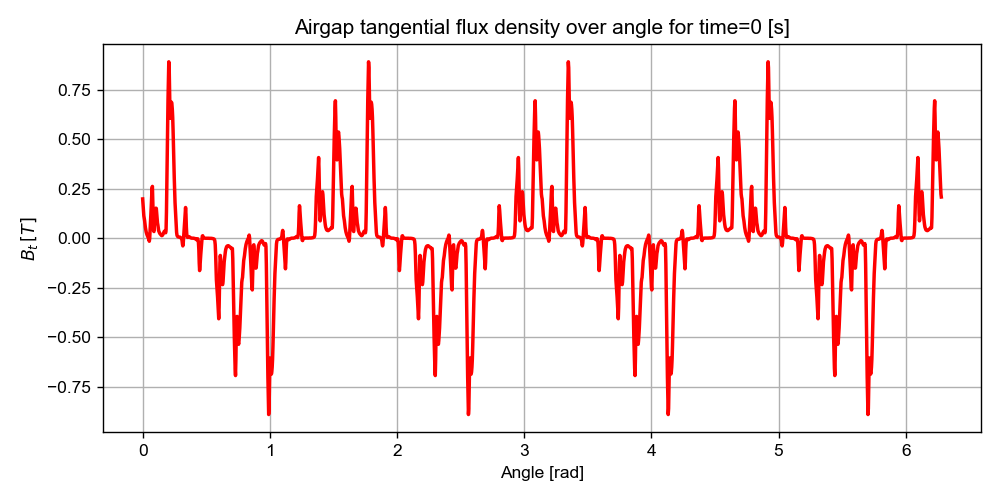

<IPython.core.display.Javascript object>


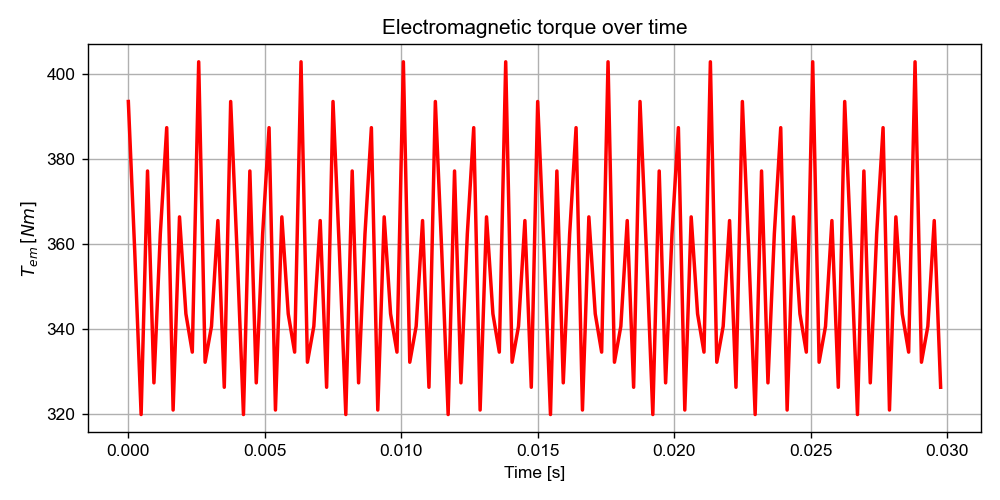

<IPython.core.display.Javascript object>


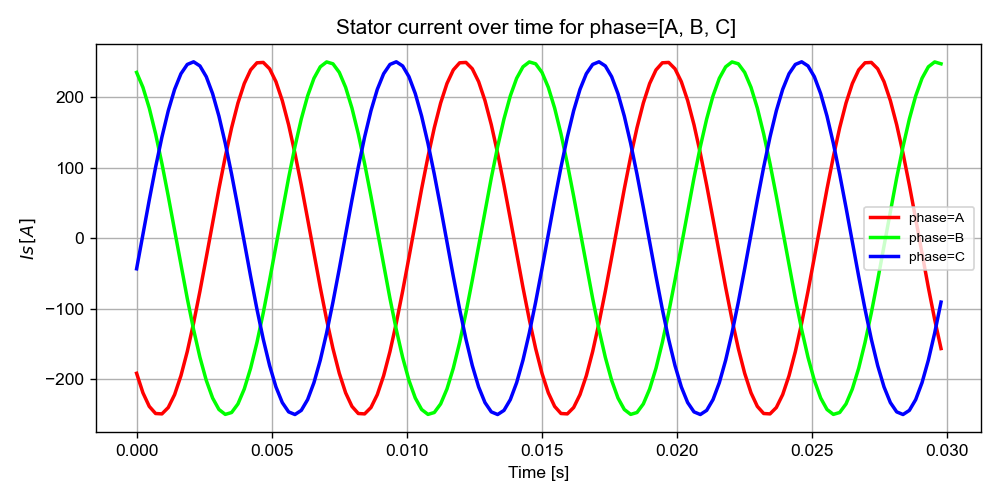

In [6]:
from pyleecan.Functions.Plot import dict_2D

out_op = simu_op.run()
# Plot the flux
out_op.mag.B.plot_2D_Data("angle", **dict_2D)
# Plot the torque
out_op.mag.Tem.plot_2D_Data("time", **dict_2D)
# Plot the current
out_op.elec.get_Is().plot_2D_Data("time", "phase", **dict_2D)

The Operating Point can also be defined directly with I0 / Phi0 with:

In [7]:
from numpy import pi

simu_op.input.set_Id_Iq(I0=I0_rms, Phi0=Phi0)
print("Id: "+str(simu_op.input.Id_ref))
print("Iq: "+str(simu_op.input.Iq_ref))

Id: -135.4188051049254
Iq: 113.62986941801093


## Iterating on several Operating Point

Each pyleecan simulation is assumed to be quasi-static and run on a single operating point (fixed speed). To run a simulation on several operating points two steps are needed: First define a simulation that run correctly on a single operating point (like the one defined above), then define a VarLoadCurrent object. 

The VarLoadCurrent object is defined with a matrix with each line corresponding to an operating point and the column are:
- (N0, I0, Phi0) if type_OP_matrix==0
- (N0, Id, Iq) if type_OP_matrix==1

The following VarLoadCurrent object will run the previous simulation N_simu times by changing the value of Phi0. 

A fourth column can be added by setting is_torque=True. It enables to define the reference torque for the Operating Point. The reference is stored in output.elec.Tem_av_ref, the real computed torque is stored in output.mag.Tem_av.

Reference torque and current angle vector are:

In [8]:
from numpy import linspace, array, pi

Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size

In [10]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_simu,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_simu))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = I0_rms * ones((N_simu)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

# All the simulation use the same machine
# No need to draw the machine for all OP
varload.is_reuse_femm_file=True  

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


The original simulation will be duplicated N_simu times with the value of InputCurrent updated according to the matrix.

In [11]:
simu_vop = simu_op.copy()
simu_vop.var_simu = varload
# simu2.input.Nt_tot = 64
Xout = simu_vop.run()

[14:38:17] Starting running simulation tuto_Id_Iq (machine=IPMSM_A)
[14:38:17] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[14:38:17] Computing reference simulation for Variable Load
[14:38:17] Starting Magnetic module
[14:38:18] Solving time step 13 / 16 in FEMM
[14:38:19] Solving time step 1 / 16 in FEMM
[14:38:19] Solving time step 9 / 16 in FEMM
[14:38:19] Solving time step 5 / 16 in FEMM
[14:38:20] Solving time step 14 / 16 in FEMM
[14:38:21] Solving time step 2 / 16 in FEMM
[14:38:21] Solving time step 10 / 16 in FEMM
[14:38:21] Solving time step 6 / 16 in FEMM
[14:38:23] Solving time step 15 / 16 in FEMM
[14:38:23] Solving time step 3 / 16 in FEMM
[14:38:23] Solving time step 11 / 16 in FEMM
[14:38:23] Solving time step 7 / 16 in FEMM
[14:38:25] Solving time step 16 / 16 in FEMM
[14:38:25] Solving time step 4 / 16 in FEMM
[14:38:25] Solving time step 12 / 16 in FEMM
[14:38:25] Solving time step 8 / 16 in FEMM
[14:38:27] Variable Load Refe

[14:39:20] Solving time step 13 / 16 in FEMM
[14:39:22] Solving time step 10 / 16 in FEMM
[14:39:22] Solving time step 6 / 16 in FEMM
[14:39:22] Solving time step 2 / 16 in FEMM
[14:39:22] Solving time step 14 / 16 in FEMM
[14:39:23] Solving time step 11 / 16 in FEMM
[14:39:24] Solving time step 7 / 16 in FEMM
[14:39:24] Solving time step 3 / 16 in FEMM
[14:39:24] Solving time step 15 / 16 in FEMM
[14:39:25] Solving time step 8 / 16 in FEMM
[14:39:26] Solving time step 12 / 16 in FEMM
[14:39:26] Solving time step 4 / 16 in FEMM
[14:39:26] Solving time step 16 / 16 in FEMM
[14:39:28] Variable Load Results: N0=2000 [rpm], Id=-88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=2.094 [], Tem_av_ref=319 [N.m], Tem_av=323.1 [N.m], Tem_rip_pp=79.83 [N.m], Tem_rip_norm=0.2471 [-]
[============================                      ]  57%
[14:39:28] Running simulation 8/13 with N0=2000 [rpm], Id=-113.6 [Arms], Iq=135.4 [Arms]
[14:39:28] Starting Magnetic module
[14:39:28] Solving time step 13 / 1

Pyleecan will automatically extract some values from each simulation. These values are all gathered in the xoutput_dict:

In [12]:
print("Values available in XOutput:")
print(Xout.xoutput_dict.keys())

print("\nI0 for each simulation:")
print(Xout["I0"].result)
print("\nPhi0 for each simulation:")
print(Xout["Phi0"].result)

Values available in XOutput:
dict_keys(['N0', 'Id', 'Iq', 'I0', 'Phi0', 'Tem_av_ref', 'Tem_av', 'Tem_rip_pp', 'Tem_rip_norm'])

I0 for each simulation:
[176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663683, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663686, 176.77669529663683, 176.77669529663683, 176.77669529663686]

Phi0 for each simulation:
[1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966, 1.7453292519943295, 1.9198621771937625, 2.0943951023931957, 2.2689280275926285, 2.443460952792061, 2.6179938779914944, 2.7925268031909276, 2.9670597283903604, 3.141592653589793]


Any parameter in the XOutput can be plot as a function of any other

<IPython.core.display.Javascript object>


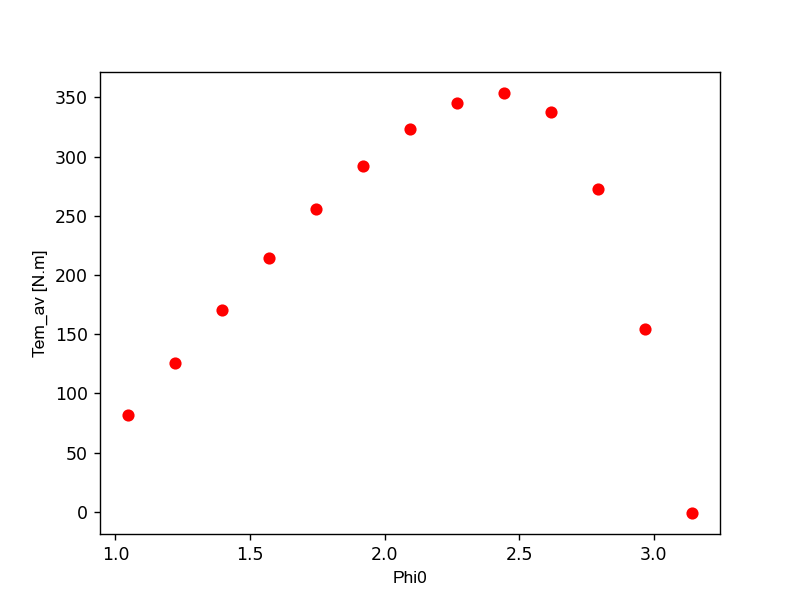

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


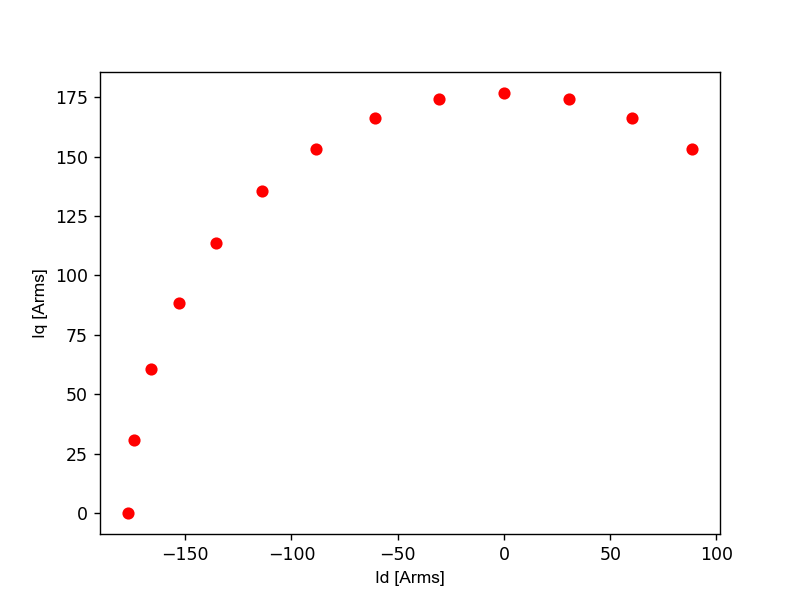

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [18]:
fig = Xout.plot_multi("Phi0", "Tem_av")
fig = Xout.plot_multi("Id", "Iq")

Finally, the computed average torque can be compared to the one in the publication from Yang et al (data has been extracted from their graph using [Engauge Digitizer](http://markummitchell.github.io/engauge-digitizer/). Note that the generic plot function `plot_2D` has been used here.

<IPython.core.display.Javascript object>


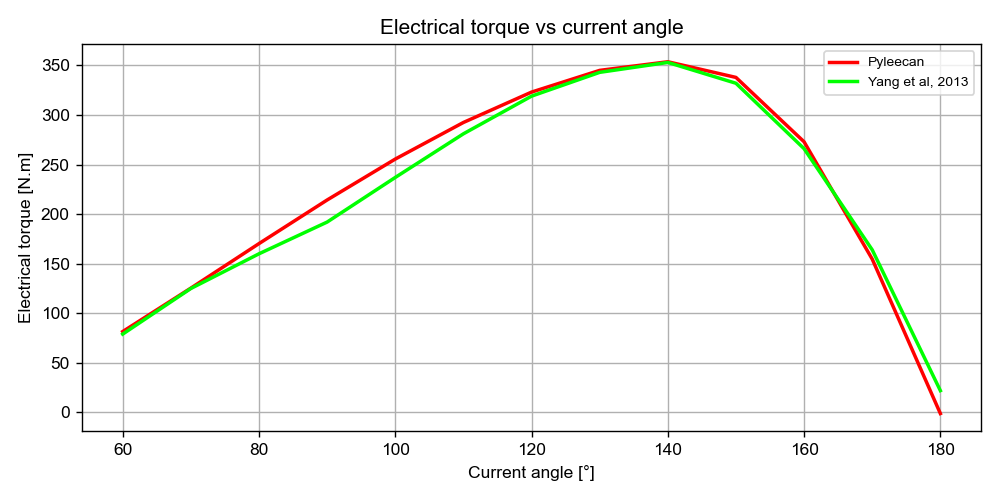

In [17]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from pyleecan.definitions import config_dict
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av"].result, Xout.xoutput_dict["Tem_av_ref"].result],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
    **dict_2D
)